# 2. Exploratory Data Analysis (EDA) Air quality
## Data Understanding (Air Quality Variables)
This section examines the distribution, variability, and temporal behaviour of weather and air quality variables. Summary statistics and visualisations are used to assess skewness, outliers, and data suitability for subsequent modelling.

- **Goal:** This EDA investigates the relationships between meteorological variables and air quality metrics to identify pollution patterns, weather temporal regimes or clusters.


### Section 2.1 Part 1: Dataset Overview (air quality variables)

In [14]:
# import package
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import os

from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from ydata_profiling import ProfileReport

In [15]:
"""

https://open-meteo.com/en/docs/air-quality-api?location_mode=csv_coordinates&csv_coordinates=34.0522,+-118.2437%0A38.5816,+-21.4944%0A42.3314,+-83.0458%0A29.7604,+-95.3698%0A41.4993,+-81.6944%0A41.8781,+-87.6298&time_mode=time_interval&start_date=2025-11-07&end_date=2026-01-05&hourly=pm10,pm2_5,carbon_monoxide,carbon_dioxide,sulphur_dioxide,ozone,nitrogen_dioxide,us_aqi. Potential biases include model representation errors, limited spatial granularity, and short temporal coverage, which may affect interpretation of meteorology–air quality relationships.

"""
#Load the dataset containing air quality variables
df = pd.read_csv("../datasets/air_quality_df.csv")

### 2.1.1 High level data Overview

In [14]:
# Loading the dataset
df = pd.read_csv("../datasets/air_quality_df.csv")
df.shape

(8640, 13)

In [23]:
# Brief view of column names
df.head(2)


,date,pm10,pm2_5,carbon_monoxide,sulphur_dioxide,ozone,us_aqi,carbon_dioxide,nitrogen_dioxide,city,country,lat,lon
0,2025-11-07 00:00:00+00:00,12.3,11.8,252.0,15.1,57.0,103.125000,466.0,29.5,Los Angeles,US,34.0522,-118.2437
1,2025-11-07 01:00:00+00:00,13.5,12.6,307.0,13.5,43.0,102.239586,472.0,38.9,Los Angeles,US,34.0522,-118.2437


### 2.1.2. a) Variable Definitions
The variables shown on columns need to be defined
#### Air Quality Data Dictionary

#### Primary Pollutants (from Open-Meteo API)

##### **Carbon Monoxide (CO)**
- **Measurement:** `carbon_monoxide`
- **Unit:** µg/m³
- **Description:** Colorless, odorless gas produced by incomplete combustion. Major sources include vehicle exhaust, industrial processes, and wildfires. High concentrations impair oxygen transport in blood.

##### **Sulphur Dioxide (SO₂)**
- **Measurement:** `sulphur_dioxide`
- **Unit:** µg/m³
- **Description:** Pungent, toxic gas primarily from burning fossil fuels containing sulfur (coal, oil). Contributes to acid rain and respiratory issues. Industrial and power generation sources dominate.

##### **Ozone (O₃)**
- **Measurement:** `ozone`
- **Unit:** µg/m³
- **Description:** Secondary pollutant formed by sunlight reacting with NOx and VOCs. Ground-level ozone harms respiratory systems and vegetation. Shows strong diurnal and seasonal patterns (higher in summer afternoons).

##### **Nitrogen Dioxide (NO₂)**
- **Measurement:** `nitrogen_dioxide`
- **Unit:** µg/m³
- **Description:** Reddish-brown gas from high-temperature combustion (vehicles, power plants). Precursor to ozone and particulate matter. Good indicator of traffic-related pollution.

##### **Carbon Dioxide (CO₂)**
- **Measurement:** `carbon_dioxide`
- **Unit:** ppm (parts per million)
- **Description:** Primary greenhouse gas from fossil fuel combustion, respiration, and decomposition. Background ~420 ppm; urban areas show elevated concentrations. Long atmospheric lifetime.

##### **Particulate Matter (PM2.5/PM10)**
*(Note: Not in your list but typically included)*
- **Measurement:** `pm2_5`, `pm10`
- **Unit:** µg/m³
- **Description:** Microscopic particles suspended in air. PM2.5 (≤2.5µm) penetrates deep into lungs; PM10 (≤10µm) includes dust, pollen. Sources: combustion, industrial processes, natural dust.

#### **Air Quality Index (AQI)**

##### **US AQI**
- **Measurement:** `us_aqi`
- **Unit:** Dimensionless index (0-500)
- **Description:** Composite index translating pollutant concentrations into health risk categories:
  - 0-50: Good (Green)
  - 51-100: Moderate (Yellow)
  - 101-150: Unhealthy for Sensitive Groups (Orange)
  - 151-200: Unhealthy (Red)
  - 201-300: Very Unhealthy (Purple)
  - 301-500: Hazardous (Maroon)
- **Calculation:** Based on worst-performing of criteria pollutants (O₃, PM2.5, PM10, CO, SO₂, NO₂)

#### **Geographic Metadata**

##### **Location Identifiers**
- **`city`**: Urban area name where measurements were taken
- **`country`**: Country code/name of measurement location
- **`lat`**: Latitude coordinate (degrees North, -90 to 90)
- **`lon`**: Longitude coordinate (degrees East, -180 to 180)

#### **Measurement Characteristics**

##### **Temporal Resolution**
- **Typical frequency:** Hourly measurements
- **Averaging period:** 1-hour means for gases, 24-hour for some standards
- **Reporting delay:** Near real-time (15-60 minute latency)

##### **Data Quality Notes**
- **Missing values:** Occur during sensor maintenance/failure
- **Detection limits:** Vary by sensor technology (typically 0.5-1 µg/m³)
- **Calibration:** Regular zero/span checks required
- **Cross-sensitivity:** Some sensors affected by humidity/temperature

#### **Health & Regulatory Context**

##### **WHO Guidelines (2021)**
- **PM2.5:** 5 µg/m³ (annual), 15 µg/m³ (24-hour)
- **PM10:** 15 µg/m³ (annual), 45 µg/m³ (24-hour)
- **NO₂:** 10 µg/m³ (annual), 25 µg/m³ (24-hour)
- **O₃:** 60 µg/m³ (peak season), 100 µg/m³ (8-hour)
- **SO₂:** 40 µg/m³ (24-hour)

##### **US EPA Standards**
- **PM2.5:** 9.0 µg/m³ (annual), 35 µg/m³ (24-hour)
- **O₃:** 70 ppb (8-hour)
- **NO₂:** 53 ppb (annual), 100 ppb (1-hour)
- **SO₂:** 75 ppb (1-hour)

---
*Source: Open-Meteo Air Quality API Documentation, WHO Air Quality Guidelines, US EPA NAAQS*

### 2.1.2 (b Missing Values Check

In [29]:
# Count missing values
df.isnull().sum().sum # Missing per column

<bound method Series.sum of date                0
pm10                0
pm2_5               0
carbon_monoxide     0
sulphur_dioxide     0
ozone               0
us_aqi              0
carbon_dioxide      0
nitrogen_dioxide    0
city                0
country             0
lat                 0
lon                 0
dtype: int64>

In [32]:
# Check dataset structure, data types, and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              8640 non-null   object 
 1   pm10              8640 non-null   float64
 2   pm2_5             8640 non-null   float64
 3   carbon_monoxide   8640 non-null   float64
 4   sulphur_dioxide   8640 non-null   float64
 5   ozone             8640 non-null   float64
 6   us_aqi            8640 non-null   float64
 7   carbon_dioxide    8640 non-null   float64
 8   nitrogen_dioxide  8640 non-null   float64
 9   city              8640 non-null   object 
 10  country           8640 non-null   object 
 11  lat               8640 non-null   float64
 12  lon               8640 non-null   float64
dtypes: float64(10), object(3)
memory usage: 877.6+ KB


#### Insights
* Date column data type is shown as objects (strings), not datetime dtype. Convert to datetime pd.to_datetime() in ETL stage

In [7]:
df.nunique().sort_values()

country                1
lon                    6
city                   6
lat                    6
ozone                104
carbon_dioxide       226
sulphur_dioxide      319
pm2_5                536
pm10                 544
carbon_monoxide      753
nitrogen_dioxide     871
date                1440
us_aqi              4404
dtype: int64

In [8]:
# Printing every distinct value in all columns
for column in df.columns:
    print(f"column: {column}", df[column].unique())

column: date ['2025-11-07 00:00:00+00:00' '2025-11-07 01:00:00+00:00'
 '2025-11-07 02:00:00+00:00' ... '2026-01-05 21:00:00+00:00'
 '2026-01-05 22:00:00+00:00' '2026-01-05 23:00:00+00:00']
column: pm10 [12.3 13.5 14.4 17.5 19.7 22.9 31.7 36.1 35.6 32.6 29.9 27.6 24.9 23.5
 24.1 26.3 28.2 25.5 22.8 20.9 19.4 17.8 16.1 14.5 17.7 19.5 21.5 23.9
 29.3 38.3 42.6 41.3 38.  32.  27.1 20.4 18.4 18.3 20.7 24.3 21.8 19.1
 19.  19.9 20.3 25.8 29.1 33.4 36.  40.4 43.8 47.5 50.8 53.  53.4 49.8
 42.1 26.9 22.2 22.6 25.1 23.3 22.4 21.4 21.2 27.2 26.7 25.6 25.4 28.9
 35.9 31.  27.7 21.1 18.2 16.9 17.4 19.8 26.5 23.7 22.5 21.6 22.7 25.
 34.5 39.5 41.1 37.7 29.6 24.7 20.5 23.4 26.6 28.3 29.  30.  32.2 35.3
 36.3 35.7 32.9 31.9 45.6 44.8 47.1 54.  58.7 58.8 48.1 32.4 29.5 27.3
 26.4 34.1 45.1 45.4 38.6 37.  41.4 46.8 47.3 44.6 41.7 39.  36.2 42.3
 45.3 32.7 26.1 18.5 17.6 18.7 27.9 30.9 26.8 18.  16.8 15.3 13.6 13.3
 14.2 12.2 11.4 11.8 12.  11.3 11.7 12.6 14.9 15.6 14.8 13.9 13.2 13.
 11.   8.8  7.   6.

#### Insights:
* No evidence of: Unit inconsistency, Type mismatch and Impossible values

### 2.1.3 Numeric EDA
* Exploring distributions and basic signals



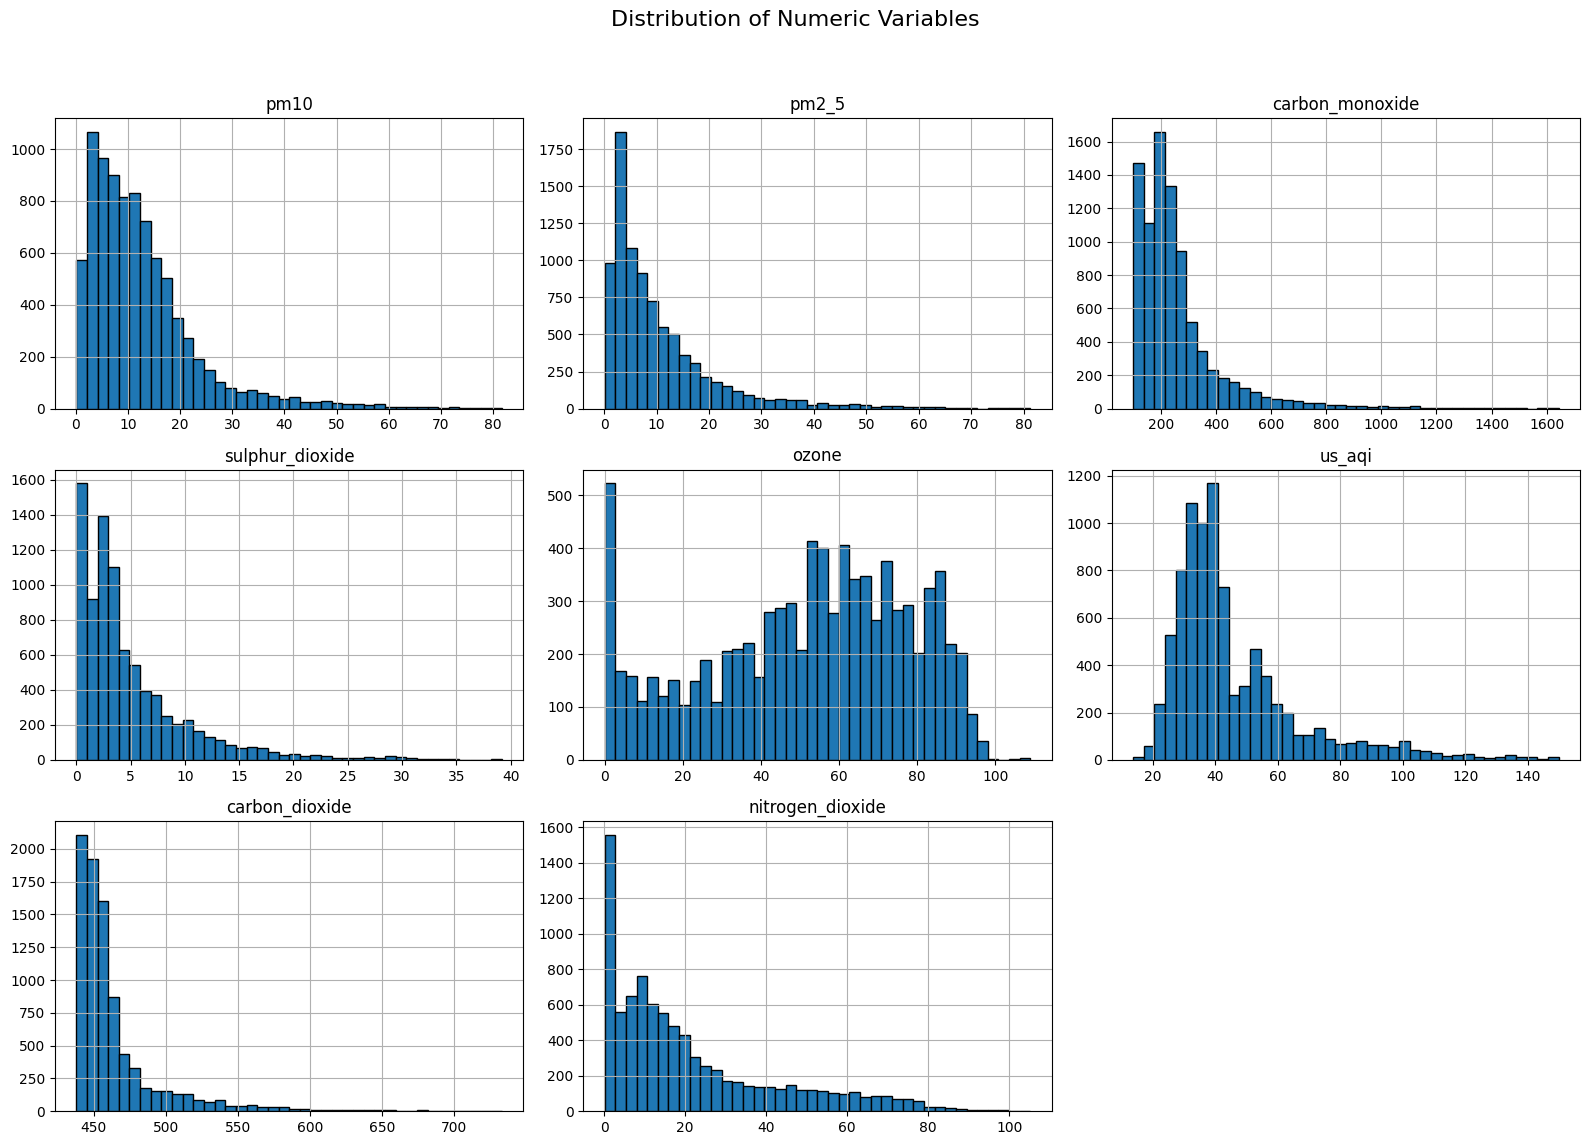

In [51]:
# Select numeric columns
numeric_cols = [
    'pm10',
    'pm2_5', 
    'carbon_monoxide',
    'sulphur_dioxide',
    'ozone',
    'us_aqi',
    'carbon_dioxide',
    'nitrogen_dioxide'
]

# Plot histograms
df[numeric_cols].hist(
    bins=40,
    figsize=(16, 12),
    edgecolor="black"
)

plt.suptitle("Distribution of Numeric Variables", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 2.1.4 Categorical EDA
* This section inspects categorical values

In [3]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols

['date', 'city', 'country']

### 2.2 Statistical analysis
This analysis applies core statistical concepts that underpin data analysis and machine learning.

**Descriptive statistics** are used to summarise the data:
- **Mean** represents the average value of a variable and provides a measure of central tendency.
- **Median** indicates the middle value of a distribution and is robust to extreme values.
- **Standard deviation** measures the spread or variability of data around the mean.

These measures are calculated using `df.describe()` and help identify skewness, outliers, and variability in environmental variables such as temperature, wind speed, and particulate matter.

In [31]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,8640,1440,2026-01-05 07:00:00+00:00,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pm10,8640.0,NaN,NaN,NaN,12.678646,10.682718,0.1,5.3,10.25,16.5,81.7
pm2_5,8640.0,NaN,NaN,NaN,10.582569,10.841096,0.1,3.3,6.9,13.7,81.3
carbon_monoxide,8640.0,NaN,NaN,NaN,259.442708,162.691291,98.0,166.0,216.0,289.25,1644.0
sulphur_dioxide,8640.0,NaN,NaN,NaN,5.03081,5.470364,0.0,1.7,3.3,6.6,39.2
ozone,8640.0,NaN,NaN,NaN,51.391551,26.515504,0.0,33.0,55.0,72.0,109.0
us_aqi,8640.0,NaN,NaN,NaN,45.847025,21.364688,13.59375,32.256945,39.250927,53.05851,149.85416
carbon_dioxide,8640.0,NaN,NaN,NaN,464.851273,34.445496,438.0,446.0,454.0,467.0,733.0
nitrogen_dioxide,8640.0,NaN,NaN,NaN,21.148762,21.249639,0.1,5.5,14.1,30.4,105.2
city,8640,6,Los Angeles,1440,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Insights
#### Pollution Levels (Health Context):
* pm2_5 mean: 10.58 WHO annual limit is 5 (WHO limit: 5 µg/m³ annual mean)
* Skewness Check:
* 
    ##### Right_skewed': pm10, pm2_5, nitrogen dioxide and sulphur_dioxide.
    ##### left_skewed': ozone and carbon_monoxide



### 2.2.1 Descriptive and exploratory analysis
This section delves into descriptive statistics such as mean, median, and exploratory analyses such as time series in order to understand the underlying data distributions and inform the downstream course for appropriate statistical methods.
#### Mean
* Mean is a measure of central tendency that represents the balance point of a dataset. Also called the average.It is calculated by summing all observations and dividing by the total number of observations.
* I will look at the mean of pm2.5 across all cities and visualise against various air quality standards:
  - WHO annual guideline (5 µg/m³)
  - US EPA annual standard (9 µg/m³)
  - US EPA 24-hour standard (35 µg/m³)
### a) Mean pm2.5 concentration per city vs air quality standards

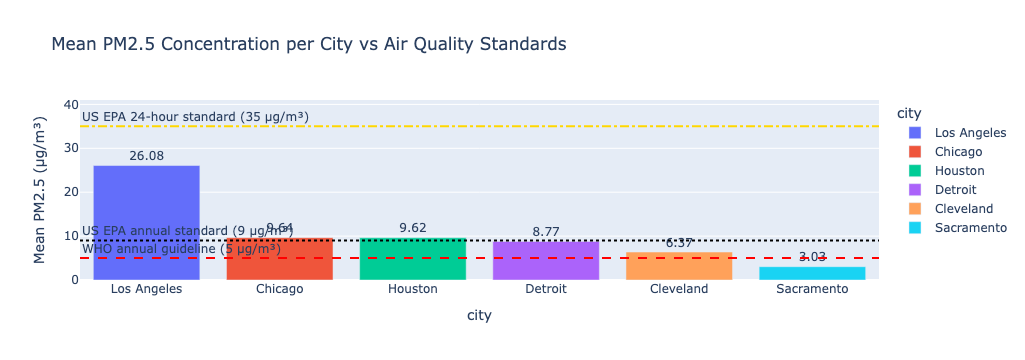

In [14]:
import plotly.express as px

# Calculate mean PM2.5 per city
city_pm25_mean = (
    df.groupby("city", as_index=False)["pm2_5"]
      .mean()
      .rename(columns={"pm2_5": "mean_pm2_5"})
)

# Sort cities by pollution level (highest first)
city_pm25_mean = city_pm25_mean.sort_values(
    "mean_pm2_5", ascending=False
)

# Create bar chart
fig = px.bar(
    city_pm25_mean,
    x="city",
    y="mean_pm2_5",
    title="Mean PM2.5 Concentration per City vs Air Quality Standards",
    labels={"mean_pm2_5": "Mean PM2.5 (µg/m³)"},
    color="city"
)

# WHO guideline (annual)
fig.add_hline(
    y=5,
    line_dash="dash",
    line_color="red",
    annotation_text="WHO annual guideline (5 µg/m³)",
    annotation_position="top left"
)

# US EPA annual standard
fig.add_hline(
    y=9,
    line_dash="dot",
    line_color="black",
    annotation_text="US EPA annual standard (9 µg/m³)",
    annotation_position="top left"
)

# US EPA 24-hour standard
fig.add_hline(
    y=35,
    line_dash="dashdot",
    line_color="gold",
    annotation_text="US EPA 24-hour standard (35 µg/m³)",
    annotation_position="top left"
)

# Show values on bars
fig.update_traces(
    texttemplate="%{y:.2f}",
    textposition="outside"
)

fig.update_layout(
    yaxis_range=[0, max(city_pm25_mean["mean_pm2_5"].max(), 36) + 5]
)

fig.show()


### Mean annual PM2.5 concentrations by city compared against WHO and US EPA air quality standards.
#### Insights
* The mean PM2.5 concentrations across all cities except Sacramento exceed WHO health-based guidelines, with several approaching or exceeding US EPA regulatory thresholds.
* “Cities are ranked by mean PM2.5 exposure, revealing which locations exceed the WHO annual guideline and therefore warrant deeper meteorological attribution analysis.


### b) Mean Air Quality Index (AQI) per city vs Good air quality standard

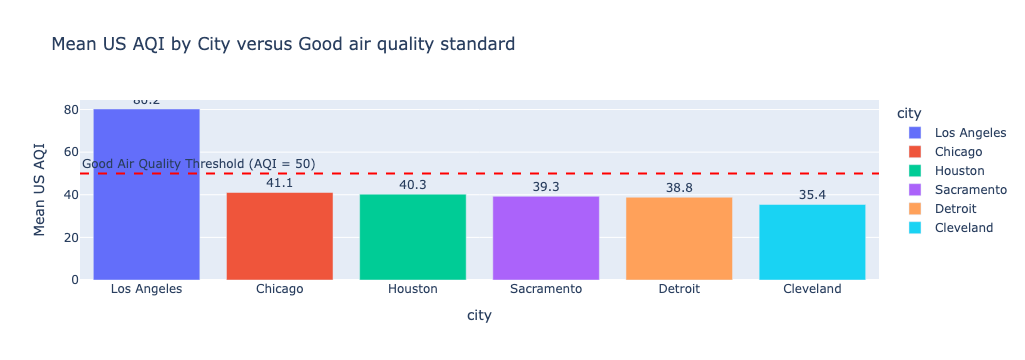

In [18]:
import plotly.express as px

# Calculate mean US AQI per city
city_aqi_mean = (
    df.groupby("city", as_index=False)["us_aqi"]
      .mean()
      .rename(columns={"us_aqi": "mean_us_aqi"})
)

# Sort worst to best
city_aqi_mean = city_aqi_mean.sort_values(
    "mean_us_aqi", ascending=False
)

# Bar plot
fig = px.bar(
    city_aqi_mean,
    x="city",
    y="mean_us_aqi",
    title="Mean US AQI by City versus Good air quality standard",
    labels={"mean_us_aqi": "Mean US AQI"},
    color="city"
)

# AQI reference line
fig.add_hline(
    y=50,
    line_dash="dash",
    line_color="red",
    annotation_text="Good Air Quality Threshold (AQI = 50)",
    annotation_position="top left"
)

fig.update_traces(
    texttemplate="%{y:.1f}",
    textposition="outside"
)

fig.show()


#### Mean annual PM2.5 concentrations by city compared against WHO and US EPA air quality standards.
#### Insights
- The mean AQI across all cities except Los Angeles do not exceed the Good air quality standard.

### 2.2.2 Time-series exploratory data analysis (EDA) 
#### a) Plot the average US AQI by City over time

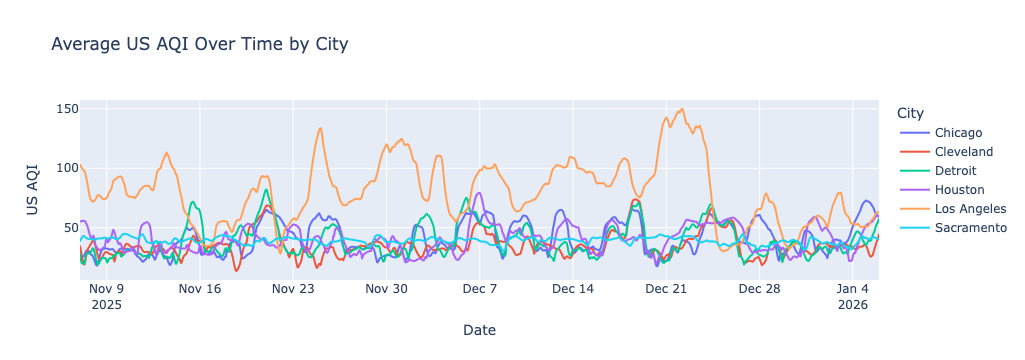

In [37]:
fig_aqi = px.line(
    df_avg,
    x="date",
    y="us_aqi",
    color="city",
    title="Average US AQI Over Time by City",
    labels={
        "date": "Date",
        "us_aqi": "US AQI",
        "city": "City"
    }
)

fig_aqi.show()


### Insights
#### Average US AQI over time by City
* Time-series of daily average US AQI values by city, highlighting trends in overall air quality over the study period.

### b) Plot Average pm2.5 by city over time (7-day Rolling average)

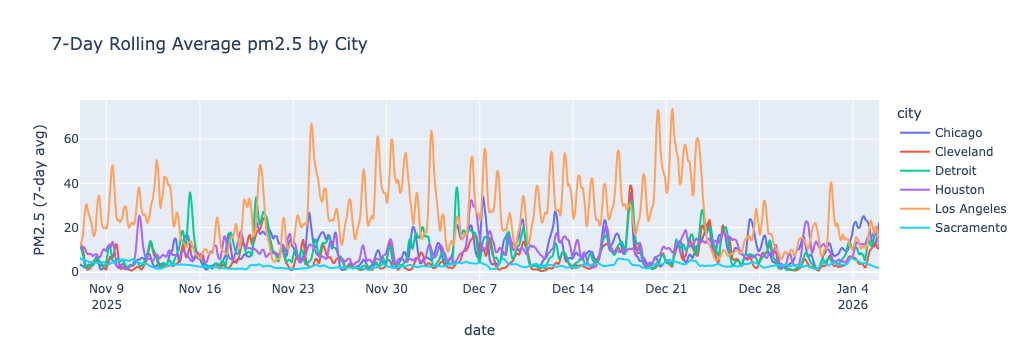

In [36]:
df_avg["pm2_5_7d"] = (
    df_avg.sort_values("date")
          .groupby("city")["pm2_5"]
          .transform(lambda x: x.rolling(7, min_periods=1).mean())
)

fig_pm25_smooth = px.line(
    df_avg,
    x="date",
    y="pm2_5_7d",
    color="city",
    title="7-Day Rolling Average pm2.5 by City",
    labels={"pm2_5_7d": "PM2.5 (7-day avg)"}
)

fig_pm25_smooth.show()


### Insights
#### Average pm2.5 over time by city
* Time-series of daily average PM2.5 concentrations by city, illustrating temporal variability and inter-city differences in particulate pollution.
* Spikesindicate events, sources, or environmental conditions.

### 2.2.3 Median
The median is the 50th percentile that splits a dataset into two halves, making it a robust measure of central tendency that is resistant to outliers and skewed distributions. A box plot provides a five-number summary visualisation that facilitates comparative analysis of distributional properties across multiple groups, with particular emphasis on central tendency robustness assessment through median comparison.

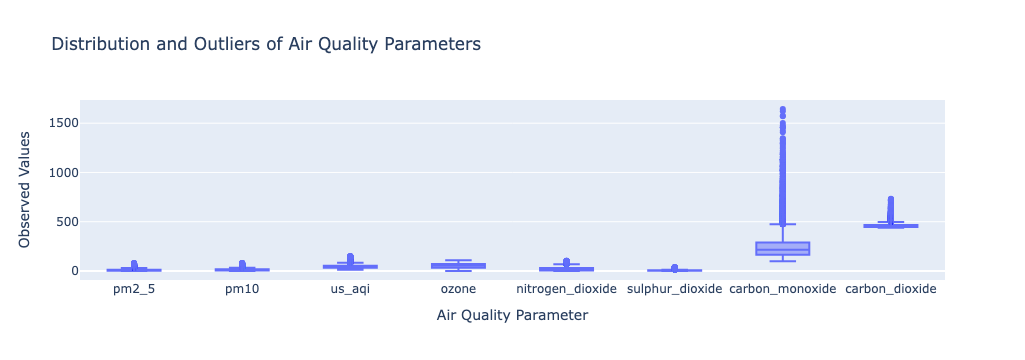

In [19]:
import plotly.express as px

# Select air quality variables only
aq_cols = [
    "pm2_5", "pm10", "us_aqi", "ozone",
    "nitrogen_dioxide", "sulphur_dioxide",
    "carbon_monoxide", "carbon_dioxide"
]

# Convert to long format
aq_long = df.melt(
    value_vars=aq_cols,
    var_name="Pollutant",
    value_name="Concentration"
)

# Box plot
fig = px.box(
    aq_long,
    x="Pollutant",
    y="Concentration",
    points="outliers",
    title="Distribution and Outliers of Air Quality Parameters"
)

fig.update_layout(
    xaxis_title="Air Quality Parameter",
    yaxis_title="Observed Values",
    showlegend=False
)

fig.show()


### Insights 
#### Box plot distribution and outliers of Air Quality Parameters
The plots illustrate skewdness of pm2.5, pm10, sulphur dioxide and carbon dioxide, whereas ozone appears to be normally distributed. Carbon monoxide displays high variance and outliers, whereas most show low variance.

### 2.3  Distribution Assessment and Normality

Before applying statistical tests or predictive models, it is important to understand the underlying data distributions. The exploratory analysis using boxplots and summary statistics shows that several environmental variables (e.g. PM2.5, precipitation, and wind speed) are skewed rather than normally distributed. This behaviour is typical of environmental and atmospheric data, where values are bounded at zero and influenced by episodic events such as pollution spikes or weather systems.

As a result, non-parametric statistical methods are preferred for inference and exploratory correlation analysis, as they do not rely on assumptions of normality. Let's do a test with pm2.5


### 2.3.1 Normality test (Shapiro-wilk-test)

In [22]:
# testing normality in pm2.5
from scipy.stats import shapiro

# Sample a subset (Shapiro-Wilk) is sensitive to very large samples)
pm25_sample = df['pm2_5'].sample(500, random_state=42)

stat, p_value = shapiro(pm25_sample)

print(f"Shapiro-Wilk Test Statistic: {stat:.4f}")
print(f"P-value: {p_value:.6f}")

if p_value < 0.05:
    print("Result: PM2.5 values are NOT normally distributed (reject H0).")
else:
    print("Result: PM2.5 values appear normally distributed (fail to reject H0).")

Shapiro-Wilk Test Statistic: 0.7904
P-value: 0.000000
Result: PM2.5 values are NOT normally distributed (reject H0).


### Interpretation of Normality Test (Shapiro-Wilk-Test)

This evaluates the null hypothesis that the data are drawn from a normal distribution.

In this analysis, the resulting p-value is below the conventional significance threshold (α = 0.05), indicating that PM2.5 concentrations do not follow a normal distribution. This confirms observations from exploratory visualisations such as boxplots and summary statistics.

Based on this result, non-parametric statistical techniques (e.g. Spearman correlation) are preferred for exploratory analysis. For machine learning, distributional assumptions are less restrictive, particularly for tree-based and ensemble models, which can handle skewed and non-linear data effectively.


### 2.3.2 Correlation Analysis
* Correlation measures the strength and direction of a linear relationship between two variables.
* Correlation shows which pollutants move together (common sources) and which move inversely (possibly different sources or atmospheric chemistry).

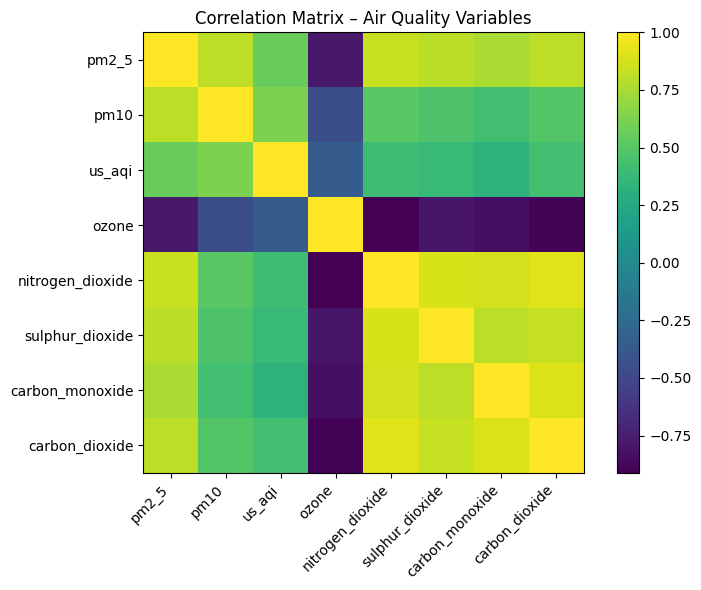

In [20]:
"""
Pearson correlation was used for exploratory analysis, while recognising the skewed distribution of air-quality variables. Correlation results were interpreted as indicative of linear association rather than causal relationships
"""
air_vars = [
    "pm2_5", "pm10", "us_aqi", "ozone",
    "nitrogen_dioxide", "sulphur_dioxide",
    "carbon_monoxide", "carbon_dioxide"
]

corr = df[air_vars].corr(method="spearman")

plt.figure(figsize=(8, 6))
im = plt.imshow(corr)
plt.colorbar(im)

plt.xticks(range(len(air_vars)), air_vars, rotation=45, ha="right")
plt.yticks(range(len(air_vars)), air_vars)

plt.title("Correlation Matrix – Air Quality Variables")
plt.tight_layout()
plt.show()


In [18]:
df[air_vars].corr(method="spearman")


,pm2_5,pm10,us_aqi,ozone,nitrogen_dioxide,sulphur_dioxide,carbon_monoxide,carbon_dioxide
pm2_5,1.000000,0.807284,0.553036,-0.778322,0.839975,0.799358,0.758449,0.811575
pm10,0.807284,1.000000,0.625830,-0.453593,0.507409,0.462884,0.421803,0.487910
us_aqi,0.553036,0.625830,1.000000,-0.352980,0.405475,0.386573,0.323950,0.429436
ozone,-0.778322,-0.453593,-0.352980,1.000000,-0.912064,-0.792725,-0.832005,-0.890656
nitrogen_dioxide,0.839975,0.507409,0.405475,-0.912064,1.000000,0.883208,0.868545,0.909252
sulphur_dioxide,0.799358,0.462884,0.386573,-0.792725,0.883208,1.000000,0.811284,0.834870
carbon_monoxide,0.758449,0.421803,0.323950,-0.832005,0.868545,0.811284,1.000000,0.900212
carbon_dioxide,0.811575,0.487910,0.429436,-0.890656,0.909252,0.834870,0.900212,1.000000


#### Correlation Insights
##### Correlation matrix of air-quality variables. 
* PM2.5 shows very strong positive correlations with PM10 (0.80), NO₂ (0.83), SO₂ (0.79), and CO (0.75), indicating shared sources such as traffic and industrial emissions.
* PM2.5 also moderately correlates with US AQI (0.55), highlighting its influence on overall air quality.
* A notable negative correlation is observed with ozone (-0.73), reflecting contrasting behaviours likely due to atmospheric chemistry or differing emission patterns.
* Correlation values provide insights into pollutant co-occurrence and interactions, useful for both monitoring and regulatory planning.

## Data and Visual Ethics Statement
All datasets and visual materials used in this notebook are either publicly available, AI-generated for illustrative purposes, or author-created. Sources are cited directly below each figure where applicable.


### Comment
A continuation of EDA can be found in the eda_weather_variables notebook. 

### 2.2 Weather forecast data profiling using Y-Profilling

In [ ]:
air_quality_df.to_csv("../Raw_data/air_quality_df.csv", index=False)
# Save weather data
weather_df.to_csv("../Raw_data/weather_df.csv", index=False)